In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - MNIST dataset

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- Activation function to introduce non-linearity: ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid are some examples of activation functions
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Nonlinearity Leaky ReLU layer


In [0]:
class LeakyReLU(Layer):
    def __init__(self):
        """Leaky ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Leaky ReLU to [batch, input_units] matrix"""
        relu_forward = np.where(input > 0, input, input * 0.01)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Leaky ReLU input"""
        relu_grad = np.where(input > 0, 1.0, 0.01)
        return grad_output*relu_grad 

### Nonlinearity TanH

In [0]:
class TanH(Layer):
    def __init__(self):
        """Hyperbolic tangent layer"""
        pass
    
    def forward(self, input):
        """Apply elementwise Hyperbolic Tangent to [batch, input_units] matrix"""
        tanh_forward = np.tanh(input)
        return tanh_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Hyperbolic Tangent input"""
        tanh_grad = 1.0-np.tanh(input)*np.tanh(input)
        return grad_output*tanh_grad 

### Nonlinearity Sigmoid

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer"""
        pass

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x)) 

    def forward(self, input):
        """Apply elementwise Sigmoid function to [batch, input_units] matrix"""
        sigmoid_forward = self.sigmoid(input)
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_grad = self.sigmoid(input)*(1.0-self.sigmoid(input))
        return grad_output*sigmoid_grad 

In [0]:
from enum import Enum, unique

@unique
class ActivationFunction(Enum):
    RELU = 1
    LEAKY_RELU = 2
    TANH = 3 # Hyperbolic tangent function
    SIGMOID = 4


def get_activation_function(activation):
    if activation == ActivationFunction.RELU:
        return ReLU()
    elif activation == ActivationFunction.LEAKY_RELU:
        return LeakyReLU()
    elif activation == ActivationFunction.TANH:
        return TanH()
    elif activation == ActivationFunction.SIGMOID:
        return Sigmoid()

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


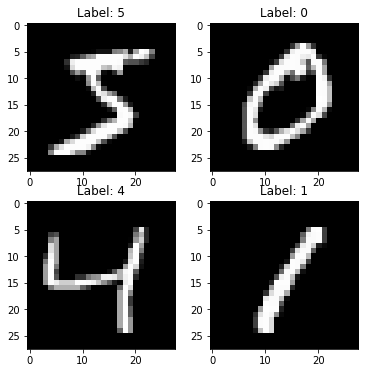

In [11]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], activation_function=ActivationFunction.RELU, print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(get_activation_function(activation_function))
    if print_network:
        print('\t\t{}()'.format(activation_function.name))
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(get_activation_function(activation_function))
      if print_network:
          print('\t\t{}()'.format(activation_function.name))
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

Define the activation function used. Using RELU.

Options:
* ActivationFunction.RELU
* ActivationFunction.LEAKY_RELU
* ActivationFunction.TANH
* ActivationFunction.SIGMOID

In [0]:
activation_function = ActivationFunction.RELU

### Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [21]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.08%
Epoch's processing time: 159.82 seconds


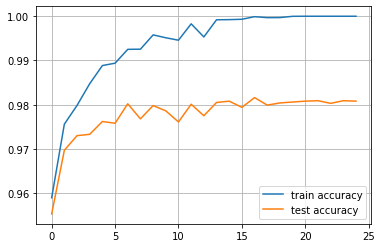

Total time: 160.00993251800537 seconds

Training accuracy list: [0.95895    0.9756     0.97983333 0.98475    0.98885    0.98938333
 0.99251667 0.99255    0.99578333 0.99513333 0.99458333 0.99828333
 0.99531667 0.9992     0.99923333 0.99931667 0.9999     0.99968333
 0.9997     0.99998333 1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.35 (+/- 0.02)


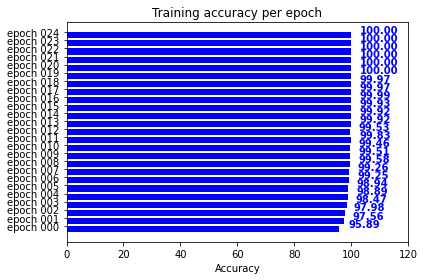


Test accuracy list: [0.9553 0.9697 0.973  0.9733 0.9762 0.9758 0.9802 0.9768 0.9798 0.9786
 0.9761 0.9801 0.9775 0.9805 0.9808 0.9794 0.9816 0.9799 0.9804 0.9806
 0.9808 0.9809 0.9803 0.9809 0.9808]
Test accuracy (Mean +/- Std): 97.76 (+/- 0.01)


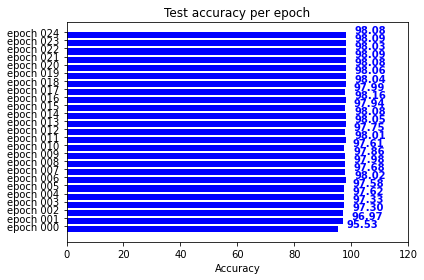


Epoch time list: [  6.53135014  12.82018518  19.10359979  25.85053515  32.16657519
  38.5238266   44.97898245  51.3594234   57.7123208   64.08566618
  70.46793723  76.69083667  82.98882818  89.23129702  95.58507061
 101.86450982 108.40816784 114.76882982 121.47587442 128.00823736
 134.45336938 140.80782366 147.14840937 153.44204235 159.81874633]
Epoch time (Mean +/- Std): 83.13 (+/- 92.09)


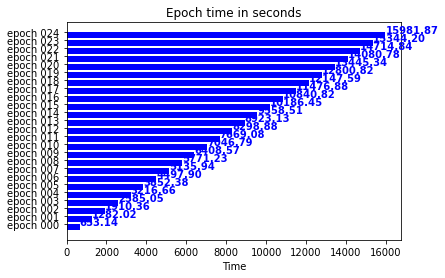

In [22]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [23]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 250.28 seconds


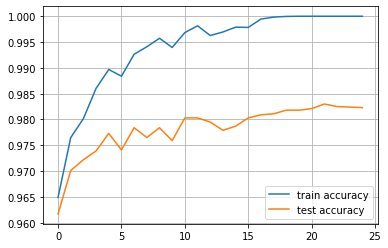

Total time: 250.48264479637146 seconds

Training accuracy list: [0.96488333 0.97648333 0.98016667 0.98603333 0.98968333 0.98838333
 0.99263333 0.99408333 0.99573333 0.99395    0.99683333 0.99815
 0.99626667 0.99695    0.99788333 0.99783333 0.99945    0.99983333
 0.99996667 1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.38 (+/- 0.02)


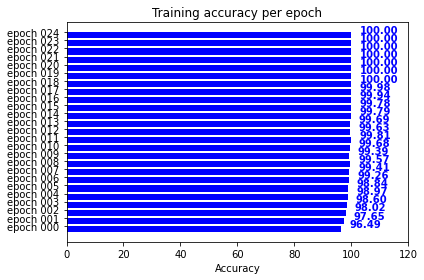


Test accuracy list: [0.9617 0.9701 0.9722 0.9739 0.9773 0.9741 0.9784 0.9765 0.9784 0.9759
 0.9803 0.9803 0.9795 0.9779 0.9787 0.9803 0.9809 0.9811 0.9818 0.9818
 0.9821 0.983  0.9825 0.9824 0.9823]
Test accuracy (Mean +/- Std): 97.81 (+/- 0.01)


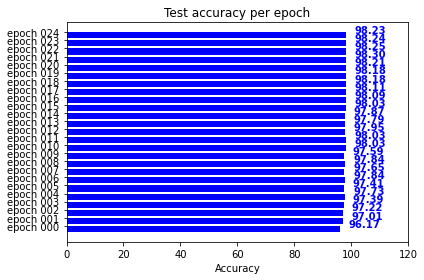


Epoch time list: [  9.77021098  19.65773487  29.8805449   39.87360406  49.95106721
  60.07971764  69.94771624  79.9394908   89.96448326  99.99658108
 109.99366331 120.04129267 130.09660435 139.99885559 150.27419806
 160.51903176 170.53338861 180.71675396 190.47773457 200.41612601
 210.36509538 220.31338263 230.23495889 240.18753242 250.27928185]
Epoch time (Mean +/- Std): 130.14 (+/- 144.63)


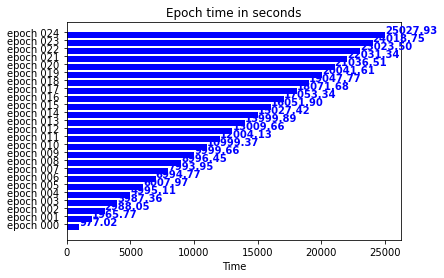

In [24]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [25]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 97.94%
Epoch's processing time: 400.23 seconds


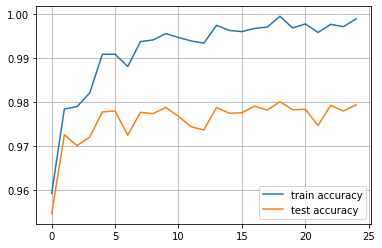

Total time: 400.42443895339966 seconds

Training accuracy list: [0.95926667 0.97846667 0.97898333 0.9821     0.9909     0.99091667
 0.98811667 0.99376667 0.99416667 0.9956     0.99471667 0.99393333
 0.99343333 0.99748333 0.99633333 0.99605    0.99678333 0.99708333
 0.99955    0.99688333 0.9978     0.99586667 0.99771667 0.99716667
 0.99895   ]
Training accuracy (Mean +/- Std): 99.21 (+/- 0.02)


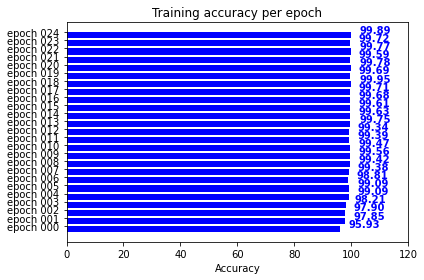


Test accuracy list: [0.9546 0.9726 0.9701 0.9721 0.9778 0.978  0.9725 0.9777 0.9774 0.9788
 0.9768 0.9744 0.9737 0.9788 0.9775 0.9776 0.9791 0.9782 0.9801 0.9783
 0.9784 0.9747 0.9793 0.978  0.9794]
Test accuracy (Mean +/- Std): 97.58 (+/- 0.01)


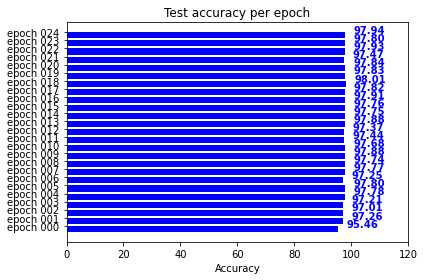


Epoch time list: [ 16.16930008  32.23900318  48.25298977  64.12904334  79.81367707
  95.54792285 111.61401725 127.83754802 143.46635532 159.29291558
 175.2525034  191.12324238 206.94535255 223.26992035 239.36683559
 255.28573298 271.29410863 287.30291986 303.33910537 319.39168859
 335.75151205 351.73407888 367.94485641 384.04635406 400.22556067]
Epoch time (Mean +/- Std): 207.63 (+/- 230.60)


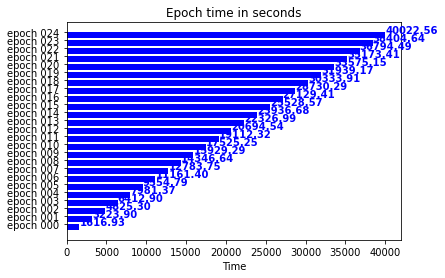

In [26]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [27]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		RELU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 98.09%
Epoch's processing time: 641.91 seconds


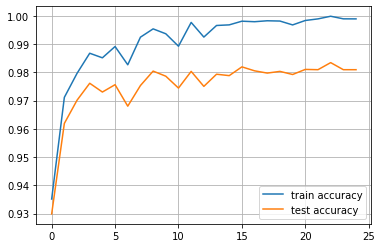

Total time: 642.1170573234558 seconds

Training accuracy list: [0.93516667 0.97111667 0.9796     0.98671667 0.9851     0.9891
 0.98263333 0.9924     0.99533333 0.9936     0.9892     0.99761667
 0.99243333 0.99653333 0.99675    0.99805    0.99786667 0.9982
 0.9981     0.99673333 0.9983     0.99886667 0.9998     0.99888333
 0.99886667]
Training accuracy (Mean +/- Std): 99.07 (+/- 0.03)


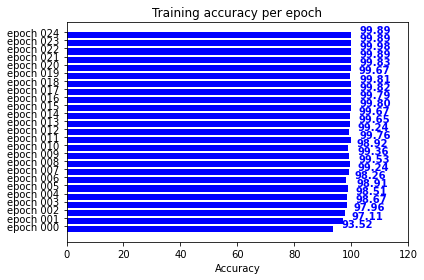


Test accuracy list: [0.9299 0.9619 0.9701 0.9761 0.973  0.9756 0.968  0.9753 0.9804 0.9786
 0.9744 0.9803 0.975  0.9793 0.9788 0.9819 0.9805 0.9797 0.9803 0.9792
 0.981  0.9809 0.9834 0.9809 0.9809]
Test accuracy (Mean +/- Std): 97.54 (+/- 0.02)


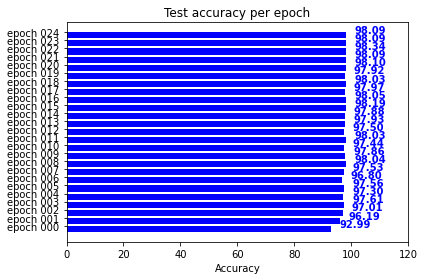


Epoch time list: [ 26.16618657  52.1151638   78.04786205 103.93492961 129.94363976
 155.99734592 181.49614334 207.12570405 232.74332213 258.25579953
 283.47239542 308.8278091  334.33873606 359.80689502 385.15700889
 410.34954953 435.76088405 461.80858326 487.59225512 513.41515851
 539.6087172  565.41621065 590.62417078 616.14298344 641.90667224]
Epoch time (Mean +/- Std): 334.40 (+/- 369.26)


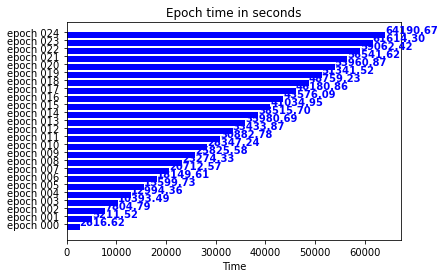

In [28]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

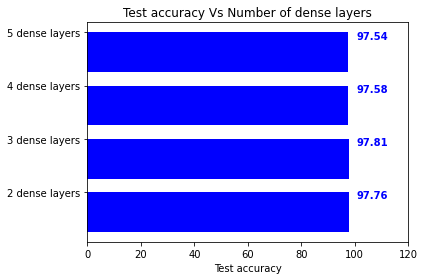

In [29]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [31]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 248.08 seconds


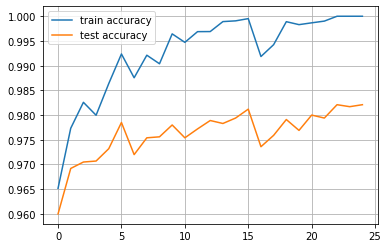

Total time: 248.2823042869568 seconds

Training accuracy list: [0.96518333 0.97733333 0.98258333 0.97996667 0.98638333 0.99236667
 0.98755    0.99211667 0.99038333 0.99643333 0.99471667 0.99688333
 0.9969     0.99891667 0.99906667 0.99951667 0.99185    0.99425
 0.9989     0.9983     0.99866667 0.99901667 1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.27 (+/- 0.02)


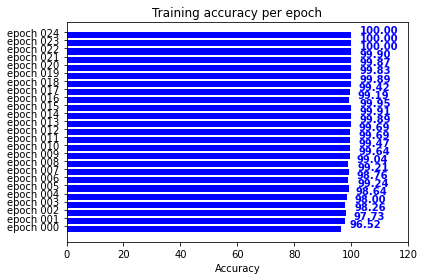


Test accuracy list: [0.96   0.9692 0.9705 0.9707 0.9732 0.9785 0.972  0.9754 0.9756 0.978
 0.9754 0.9772 0.9789 0.9783 0.9794 0.9812 0.9736 0.9759 0.9791 0.9769
 0.98   0.9794 0.9821 0.9817 0.9821]
Test accuracy (Mean +/- Std): 97.62 (+/- 0.01)


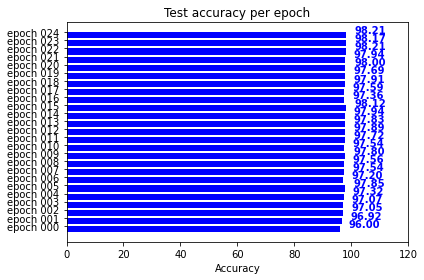


Epoch time list: [  9.771981    19.89951205  29.85474777  40.07784414  50.00534391
  59.86290503  69.70835733  79.52903748  89.15342951  98.92861891
 108.65425944 118.40817428 128.23427534 138.59864783 148.82387924
 158.72033882 168.48149824 178.55343461 188.55989099 198.36169934
 208.58839488 218.50053144 228.34486032 238.16486192 248.07968187]
Epoch time (Mean +/- Std): 128.95 (+/- 143.06)


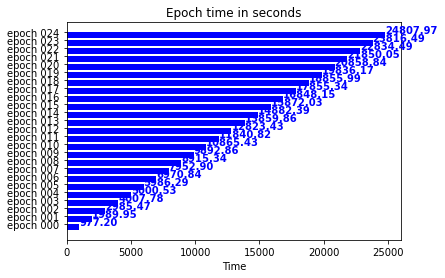

In [32]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.22%
Epoch's processing time: 248.72 seconds


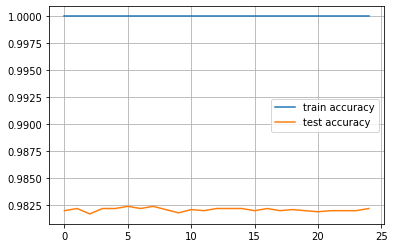

Total time: 248.92300868034363 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


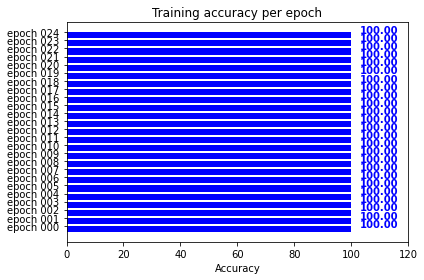


Test accuracy list: [0.982  0.9822 0.9817 0.9822 0.9822 0.9824 0.9822 0.9824 0.9821 0.9818
 0.9821 0.982  0.9822 0.9822 0.9822 0.982  0.9822 0.982  0.9821 0.982
 0.9819 0.982  0.982  0.982  0.9822]
Test accuracy (Mean +/- Std): 98.21 (+/- 0.00)


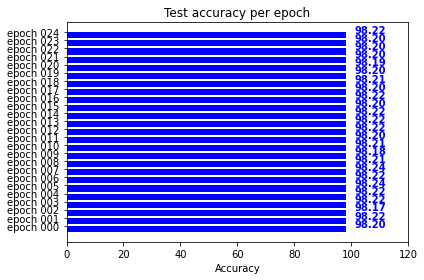


Epoch time list: [  9.65836811  19.52430201  29.50878096  39.60700655  49.57384801
  59.40839887  69.22736239  79.16881776  89.11996627  99.13203335
 108.87161207 118.57546639 128.37548089 138.25455832 149.1091938
 158.93376088 168.80631304 178.51473331 188.4283905  198.29274201
 208.62921524 218.5919354  228.46179056 238.56140852 248.71810412]
Epoch time (Mean +/- Std): 128.92 (+/- 143.48)


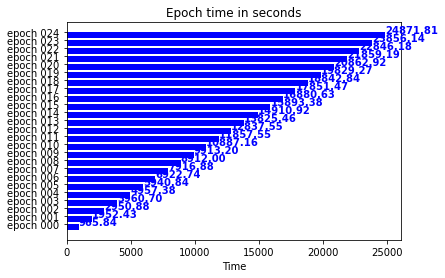

In [33]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 247.78 seconds


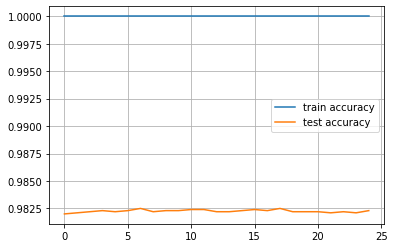

Total time: 247.98588156700134 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


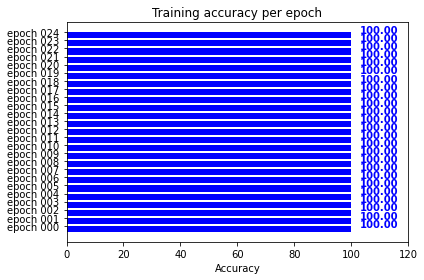


Test accuracy list: [0.982  0.9821 0.9822 0.9823 0.9822 0.9823 0.9825 0.9822 0.9823 0.9823
 0.9824 0.9824 0.9822 0.9822 0.9823 0.9824 0.9823 0.9825 0.9822 0.9822
 0.9822 0.9821 0.9822 0.9821 0.9823]
Test accuracy (Mean +/- Std): 98.23 (+/- 0.00)


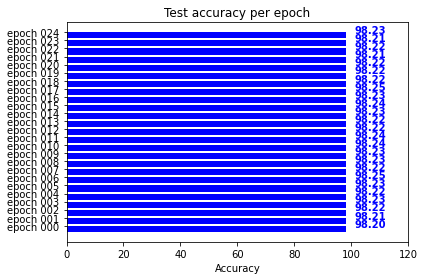


Epoch time list: [  9.84731245  20.260041    30.11730433  40.05521393  49.9905045
  59.84419823  69.5815382   79.46407747  89.25816464  98.98505783
 108.80275559 118.61894226 128.32677102 138.22388434 148.00406599
 157.71876669 167.7997191  177.92150354 188.02822876 198.14494276
 208.10670495 218.14469004 228.11287594 238.0312345  247.78042912]
Epoch time (Mean +/- Std): 128.77 (+/- 142.65)


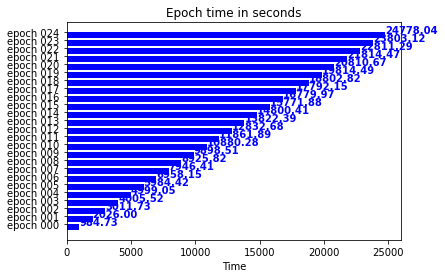

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 245.49 seconds


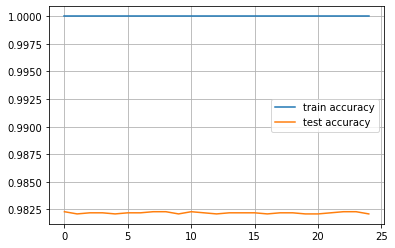

Total time: 245.7078833580017 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


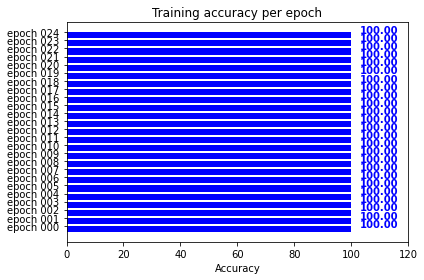


Test accuracy list: [0.9823 0.9821 0.9822 0.9822 0.9821 0.9822 0.9822 0.9823 0.9823 0.9821
 0.9823 0.9822 0.9821 0.9822 0.9822 0.9822 0.9821 0.9822 0.9822 0.9821
 0.9821 0.9822 0.9823 0.9823 0.9821]
Test accuracy (Mean +/- Std): 98.22 (+/- 0.00)


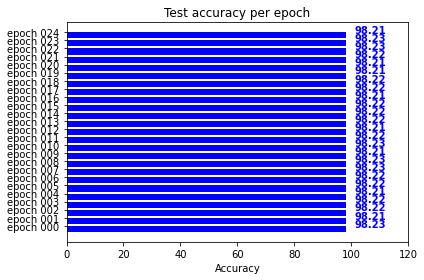


Epoch time list: [  9.55072951  19.68641686  29.9994626   40.22576904  50.09120679
  59.89044642  69.62966084  79.63240409  89.34574771  98.98251915
 108.74442291 118.73204398 128.77750015 138.70712185 148.36690712
 158.04820728 167.79965782 177.52318025 187.1881578  196.83511662
 206.57914782 216.31699491 226.05796313 235.7061398  245.49293804]
Epoch time (Mean +/- Std): 128.32 (+/- 141.43)


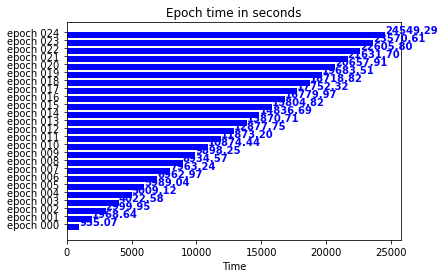

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

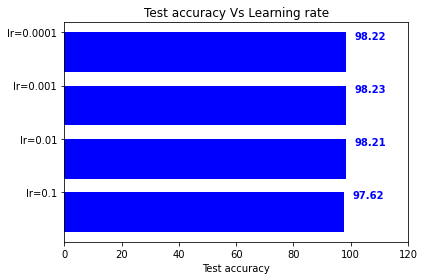

In [36]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

In [38]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 99.59%
Test accuracy: 97.88%
Epoch's processing time: 517.98 seconds


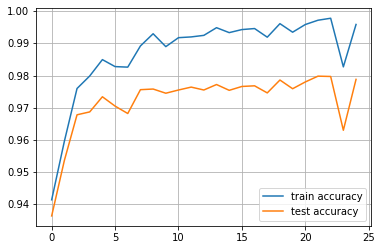

Total time: 518.1747176647186 seconds

Training accuracy list: [0.9414     0.95955    0.97596667 0.97985    0.98493333 0.98276667
 0.9826     0.98918333 0.99296667 0.98896667 0.99175    0.99198333
 0.99246667 0.99485    0.99331667 0.99426667 0.99458333 0.9919
 0.9961     0.99345    0.99583333 0.99716667 0.99778333 0.98268333
 0.99585   ]
Training accuracy (Mean +/- Std): 98.73 (+/- 0.03)


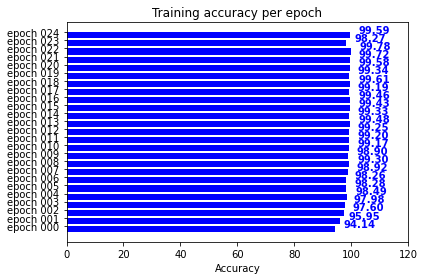


Test accuracy list: [0.9364 0.9536 0.9678 0.9687 0.9734 0.9705 0.9682 0.9756 0.9758 0.9745
 0.9755 0.9764 0.9755 0.9772 0.9754 0.9766 0.9768 0.9746 0.9786 0.9759
 0.978  0.9798 0.9797 0.963  0.9788]
Test accuracy (Mean +/- Std): 97.23 (+/- 0.02)


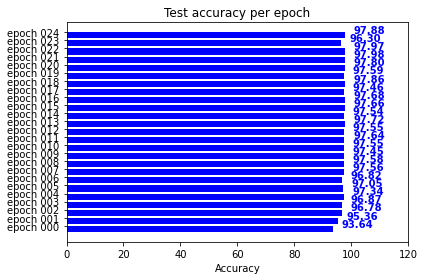


Epoch time list: [ 21.22231889  42.60614204  64.20114756  84.77094603 105.91950226
 126.71443486 147.77043939 168.43852901 188.97810054 209.30953574
 229.70921993 250.26380968 270.76423693 291.11227059 311.84203339
 332.24832773 352.68139839 373.10149956 393.38598704 413.79844141
 435.20182633 456.09437513 476.42612267 496.91244531 517.97982955]
Epoch time (Mean +/- Std): 270.46 (+/- 297.24)


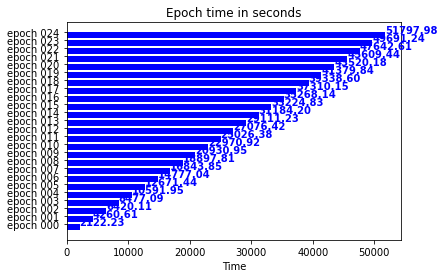

In [39]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.29%
Epoch's processing time: 327.36 seconds


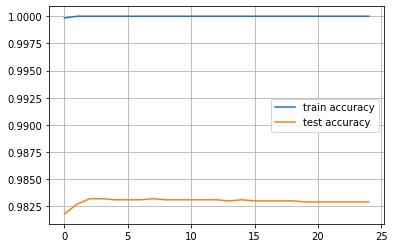

Total time: 327.5633623600006 seconds

Training accuracy list: [0.99983333 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


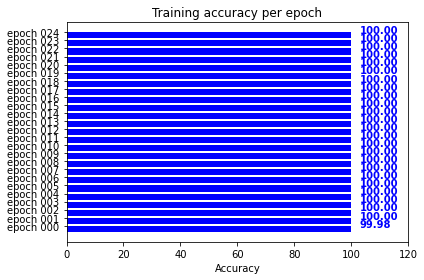


Test accuracy list: [0.9818 0.9827 0.9832 0.9832 0.9831 0.9831 0.9831 0.9832 0.9831 0.9831
 0.9831 0.9831 0.9831 0.983  0.9831 0.983  0.983  0.983  0.983  0.9829
 0.9829 0.9829 0.9829 0.9829 0.9829]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


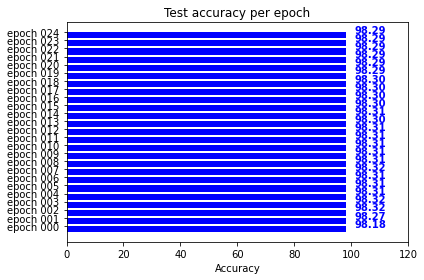


Epoch time list: [ 12.78550029  25.6970644   38.51069951  51.19651341  63.94549894
  76.63910079  89.89392853 103.41511106 116.7996943  130.30493212
 143.55561137 156.8929646  170.16479516 183.40284538 196.70341444
 209.97757268 223.19494438 237.04662824 249.96743917 262.77506065
 275.6732204  288.44626522 301.34707403 314.44448733 327.35819411]
Epoch time (Mean +/- Std): 170.01 (+/- 190.13)


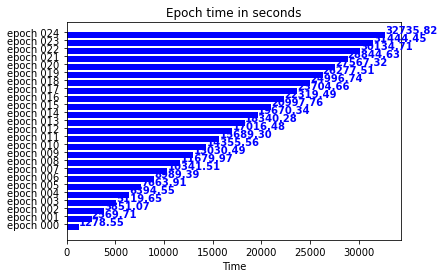

In [40]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 239.26 seconds


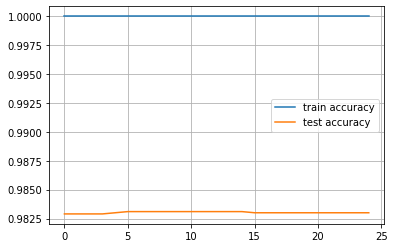

Total time: 239.4605929851532 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


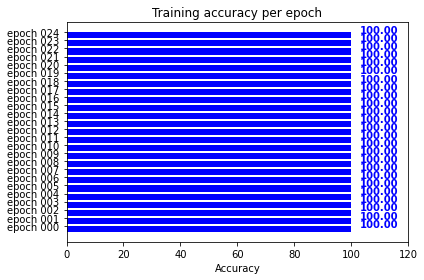


Test accuracy list: [0.9829 0.9829 0.9829 0.9829 0.983  0.9831 0.9831 0.9831 0.9831 0.9831
 0.9831 0.9831 0.9831 0.9831 0.9831 0.983  0.983  0.983  0.983  0.983
 0.983  0.983  0.983  0.983  0.983 ]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


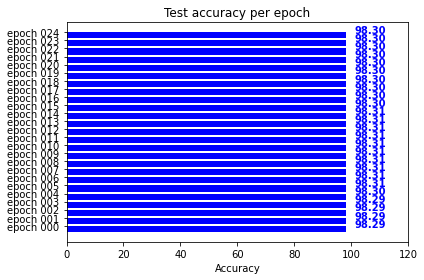


Epoch time list: [  9.47140074  19.00342655  28.76739836  38.48748684  47.96829247
  57.57185769  67.19394112  76.64013052  85.91332078  95.23646283
 104.53400755 113.89291406 123.21040154 132.60772109 141.93836117
 151.22220397 160.96969962 170.31870818 179.75384474 189.46657729
 199.0027957  209.05946016 219.55390716 229.59126997 239.25953078]
Epoch time (Mean +/- Std): 123.63 (+/- 137.06)


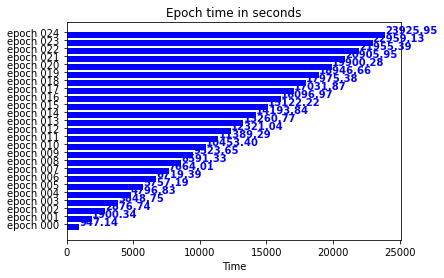

In [41]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 181.63 seconds


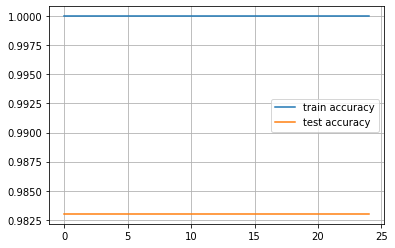

Total time: 181.82820916175842 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


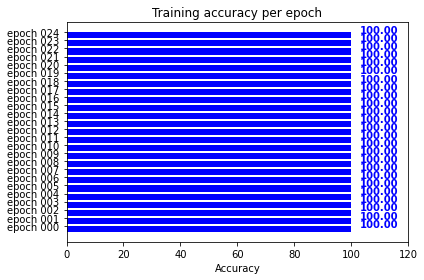


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


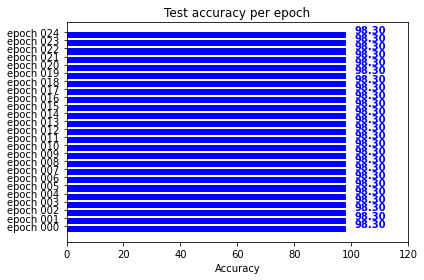


Epoch time list: [  7.04718232  14.17910838  21.41682148  28.609236    35.92346978
  43.13669586  50.30437875  57.46927118  64.61584115  71.72427869
  78.78655744  85.92483902  93.16307616 100.47408581 107.62542653
 114.90118814 122.07978368 129.36286187 137.75600767 145.78357244
 153.02624202 160.33557796 167.39879727 174.57287002 181.62789631]
Epoch time (Mean +/- Std): 93.89 (+/- 105.13)


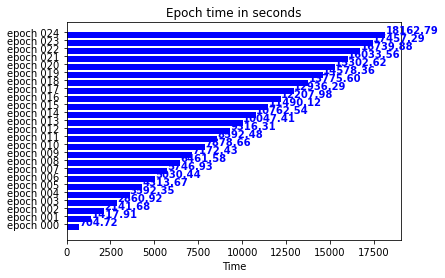

In [42]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 157.46 seconds


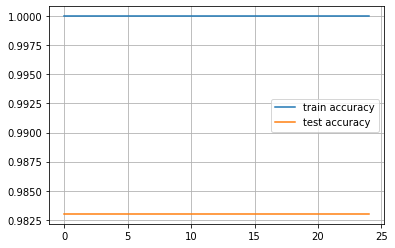

Total time: 157.67435216903687 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


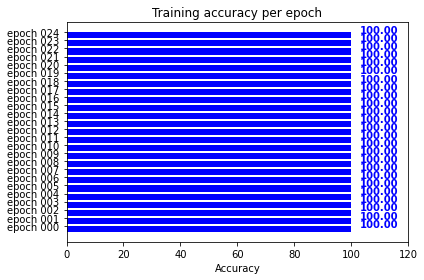


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


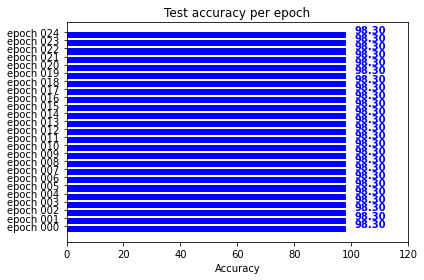


Epoch time list: [  6.08554959  12.35476565  18.55931067  24.78335571  31.05909562
  37.40077424  43.65082955  49.88376284  56.05736971  62.26105165
  68.49811172  74.71569657  81.22950387  87.51903772  93.79719234
 100.26336718 106.68669343 113.21199322 119.659513   126.21201348
 132.50714135 138.7832315  144.9784832  151.25650501 157.45926738]
Epoch time (Mean +/- Std): 81.55 (+/- 91.20)


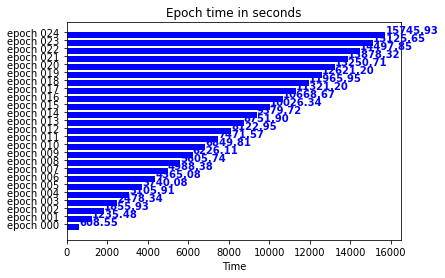

In [43]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

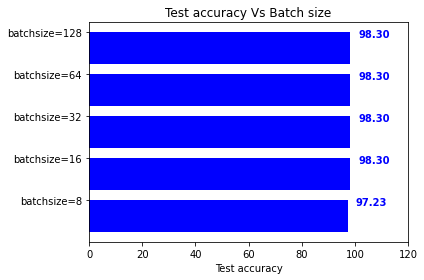

In [44]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different activation functions

* Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

### Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

In [46]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.93%
Test accuracy: 97.95%
Epoch's processing time: 167.90 seconds


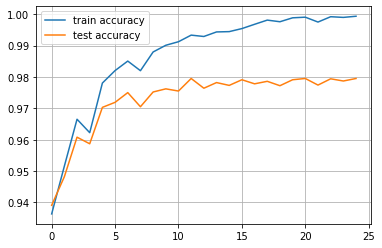

Total time: 168.0959873199463 seconds

Training accuracy list: [0.93635    0.95156667 0.96651667 0.96223333 0.97805    0.98201667
 0.98505    0.98198333 0.98795    0.99008333 0.99121667 0.99331667
 0.99288333 0.99433333 0.99443333 0.9954     0.99676667 0.9981
 0.99758333 0.99883333 0.99903333 0.99748333 0.99918333 0.99896667
 0.99933333]
Training accuracy (Mean +/- Std): 98.67 (+/- 0.03)


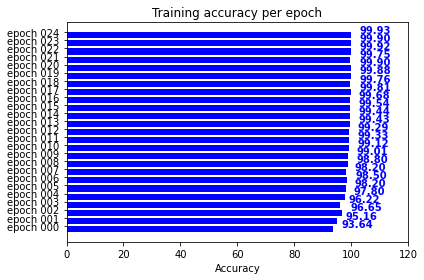


Test accuracy list: [0.9391 0.9482 0.9608 0.9587 0.9703 0.9719 0.975  0.9705 0.9752 0.9762
 0.9755 0.9795 0.9764 0.9782 0.9773 0.9791 0.9778 0.9786 0.9772 0.9791
 0.9795 0.9774 0.9794 0.9787 0.9795]
Test accuracy (Mean +/- Std): 97.28 (+/- 0.02)


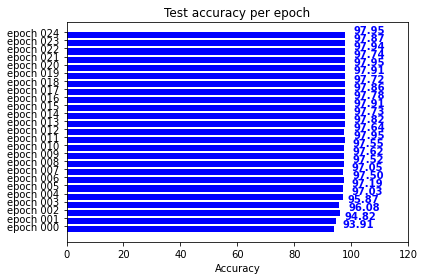


Epoch time list: [  6.47407699  13.2219739   19.86296296  26.7783134   33.48143411
  40.27278209  46.99020839  53.73236799  60.46427894  67.12501836
  73.90948391  80.60195231  87.37025642  94.04169774 100.74032569
 107.48059297 114.22818661 121.16506791 127.88132215 134.58673024
 141.25254989 147.9209516  154.53110886 161.18151236 167.90209913]
Epoch time (Mean +/- Std): 87.33 (+/- 97.07)


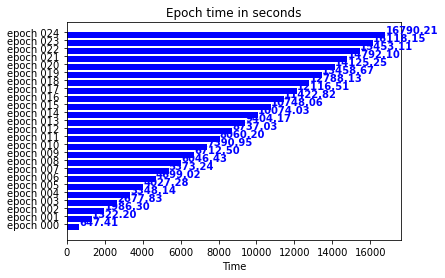

In [47]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

In [48]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.LEAKY_RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.92%
Test accuracy: 97.84%
Epoch's processing time: 173.93 seconds


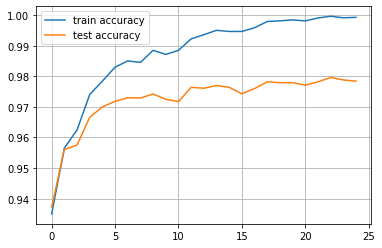

Total time: 174.12634229660034 seconds

Training accuracy list: [0.93503333 0.95656667 0.96245    0.97405    0.97841667 0.98298333
 0.98501667 0.98453333 0.98848333 0.98715    0.98846667 0.99223333
 0.99358333 0.99501667 0.99465    0.99465    0.99585    0.9979
 0.99811667 0.99841667 0.9981     0.99905    0.99961667 0.99911667
 0.99925   ]
Training accuracy (Mean +/- Std): 98.71 (+/- 0.03)


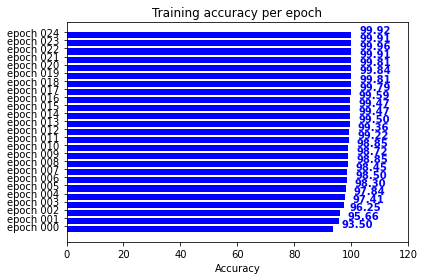


Test accuracy list: [0.9373 0.9561 0.9575 0.9666 0.97   0.9718 0.973  0.9729 0.9742 0.9725
 0.9717 0.9764 0.9761 0.977  0.9764 0.9743 0.976  0.9782 0.9779 0.9779
 0.9771 0.9782 0.9796 0.9788 0.9784]
Test accuracy (Mean +/- Std): 97.22 (+/- 0.02)


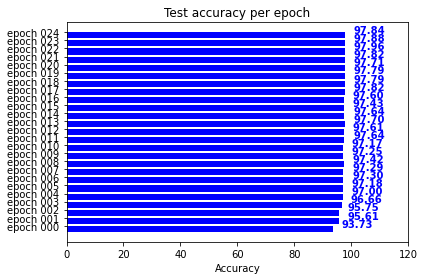


Epoch time list: [  6.64658046  13.50571871  20.40872335  27.28029156  34.24157953
  41.16960573  48.05307555  54.95400357  61.85657382  68.79069638
  75.69446588  82.85844707  89.7853508   96.66752625 103.66552329
 110.75806427 117.82258081 125.08797479 132.03562355 138.94667411
 146.00699782 153.02569461 159.96188736 166.94444275 173.92958689]
Epoch time (Mean +/- Std): 90.00 (+/- 100.68)


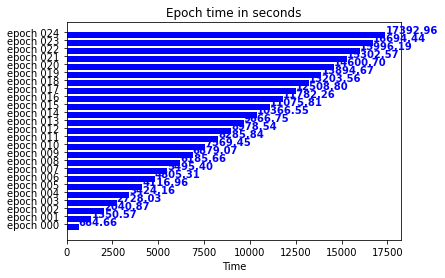

In [49]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)


### Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

In [50]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.TANH, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		TANH()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		TANH()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		TANH()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.87%
Test accuracy: 97.67%
Epoch's processing time: 323.15 seconds


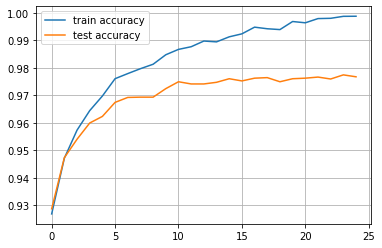

Total time: 323.3548765182495 seconds

Training accuracy list: [0.92685    0.94711667 0.9573     0.9644     0.96971667 0.97601667
 0.97786667 0.97965    0.98126667 0.98471667 0.98666667 0.98763333
 0.9897     0.9894     0.99123333 0.99231667 0.99475    0.99416667
 0.99386667 0.9968     0.99633333 0.99786667 0.99796667 0.99868333
 0.99871667]
Training accuracy (Mean +/- Std): 98.28 (+/- 0.04)


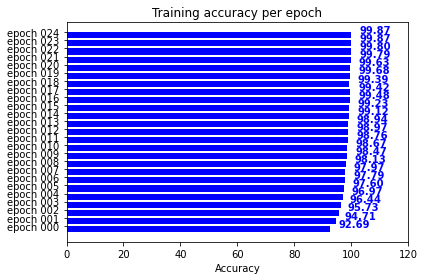


Test accuracy list: [0.9287 0.9473 0.954  0.9599 0.9623 0.9674 0.9692 0.9693 0.9693 0.9724
 0.9749 0.9741 0.9741 0.9747 0.976  0.9752 0.9762 0.9764 0.9749 0.976
 0.9762 0.9766 0.9759 0.9774 0.9767]
Test accuracy (Mean +/- Std): 96.94 (+/- 0.02)


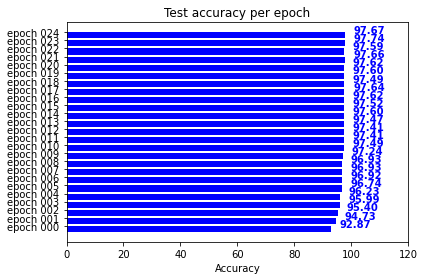


Epoch time list: [ 12.69652891  25.42825341  38.10497212  50.77182841  63.61315393
  76.36025047  89.13752389 102.03428054 114.79660892 127.87451148
 140.82169652 153.80127788 166.68881655 179.61968899 192.5536356
 205.57599211 218.73474598 231.71162176 244.73077178 258.01589632
 271.05807734 284.10149717 297.08167362 310.15921092 323.15251517]
Epoch time (Mean +/- Std): 167.15 (+/- 186.81)


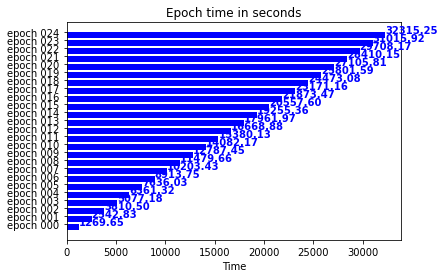

In [51]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

In [52]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.SIGMOID, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 95.88%
Test accuracy: 95.55%
Epoch's processing time: 278.32 seconds


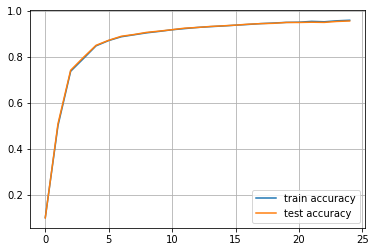

Total time: 278.70370411872864 seconds

Training accuracy list: [0.10125    0.50075    0.73696667 0.79175    0.84741667 0.87048333
 0.88705    0.8956     0.9041     0.9104     0.91738333 0.92253333
 0.92753333 0.93088333 0.93378333 0.9373     0.9405     0.94423333
 0.9467     0.94948333 0.9503     0.95393333 0.95218333 0.95643333
 0.95878333]
Training accuracy (Mean +/- Std): 86.27 (+/- 0.37)


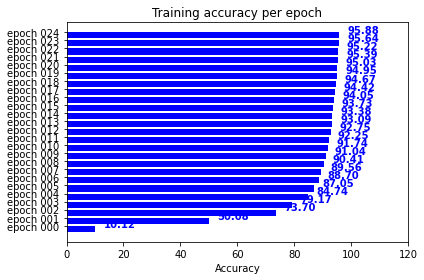


Test accuracy list: [0.0997 0.5087 0.7415 0.7969 0.8497 0.8717 0.8892 0.8968 0.9061 0.9116
 0.9177 0.9244 0.9274 0.9317 0.9345 0.9375 0.9416 0.9441 0.9455 0.9492
 0.9491 0.9502 0.9494 0.9536 0.9555]
Test accuracy (Mean +/- Std): 86.33 (+/- 0.36)


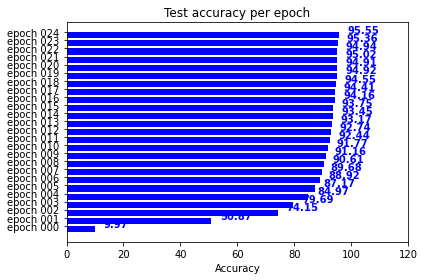


Epoch time list: [ 10.89134049  22.11159468  33.22328734  44.65914989  55.8276751
  67.05256295  78.33461642  89.55352354 100.83338857 112.09681988
 123.24177289 134.26713395 145.29816842 156.33786941 167.36633515
 178.40047765 189.46077895 200.69233322 211.76749539 222.77655983
 233.73616934 244.95605946 256.18026209 267.24400473 278.32213593]
Epoch time (Mean +/- Std): 144.99 (+/- 160.54)


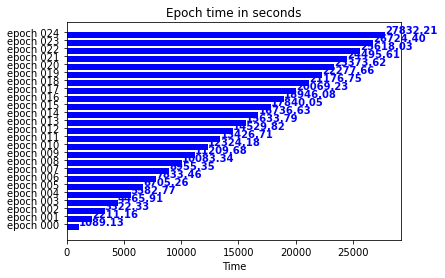

In [53]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best activation functions

* Highest test accuracy (mean)

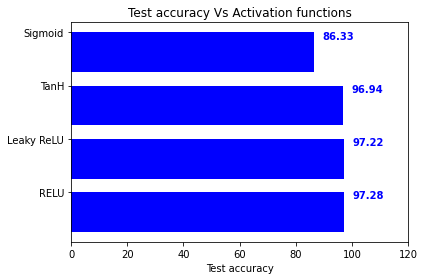

In [54]:
# ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid 
labels = ['RELU', 'Leaky ReLU', 'TanH', 'Sigmoid']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Activation functions', use_xlim=True)

## Conclusion: Best MLP model

### Best MLP model: 
**Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with batchsize=32, shuffle=True**

In [59]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.97%
Test accuracy: 98.22%
Epoch's processing time: 251.90 seconds


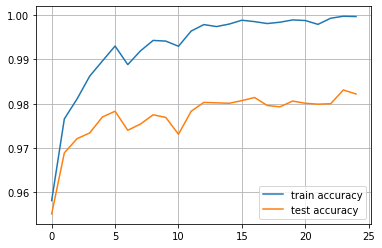

Total time: 252.10001873970032 seconds

Training accuracy list: [0.95811667 0.97658333 0.98106667 0.98623333 0.98965    0.99303333
 0.98883333 0.99193333 0.9943     0.99415    0.99298333 0.99641667
 0.99788333 0.99743333 0.998      0.99886667 0.99855    0.99811667
 0.99841667 0.99893333 0.9988     0.99793333 0.99931667 0.99976667
 0.9997    ]
Training accuracy (Mean +/- Std): 99.30 (+/- 0.02)


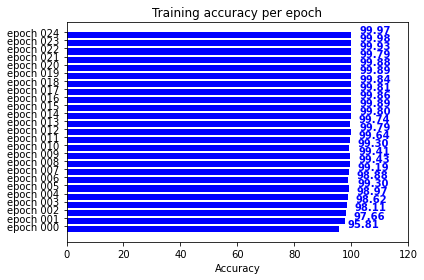


Test accuracy list: [0.9551 0.9689 0.9721 0.9734 0.977  0.9783 0.974  0.9754 0.9775 0.9769
 0.9731 0.9783 0.9803 0.9802 0.9801 0.9807 0.9814 0.9796 0.9793 0.9806
 0.9801 0.9799 0.98   0.9831 0.9822]
Test accuracy (Mean +/- Std): 97.71 (+/- 0.01)


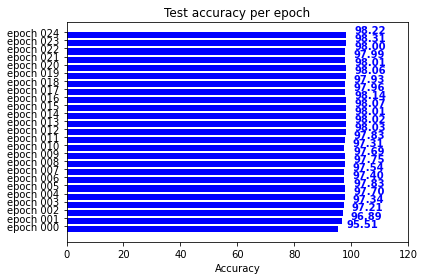


Epoch time list: [  9.99879098  20.18093061  30.27617741  40.43962884  50.4670887
  60.54889297  70.58558726  80.561903    90.54513884 100.49953794
 110.51215076 120.55684566 130.50176144 140.61456323 150.71614361
 160.97164369 171.15263462 181.50158024 191.66011834 201.74329233
 211.79952121 221.80378532 231.95504737 241.93007922 251.90434217]
Epoch time (Mean +/- Std): 130.94 (+/- 145.39)


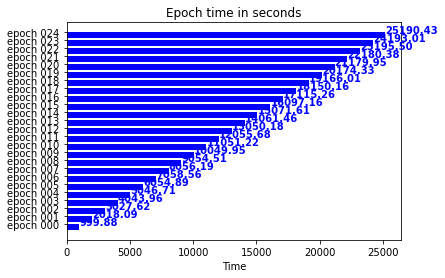

In [60]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

**Reference:** 

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9